In [98]:
# download cifar-10 dataset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

cifar10 = CIFAR10(root="data", download=True)

Files already downloaded and verified


In [97]:
import model

yoloModel = model.YOLOv3(num_classes=80)  


In [71]:
import torch.nn as nn
from torch import randn
# Add file path to the system path

config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]



class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x


class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

# bayesian neural network
class Bayesian(nn.Module):
    

Files already downloaded and verified


(32, 32, 3)
torch.Size([3, 32, 32])
torch.Size([10, 32, 32])


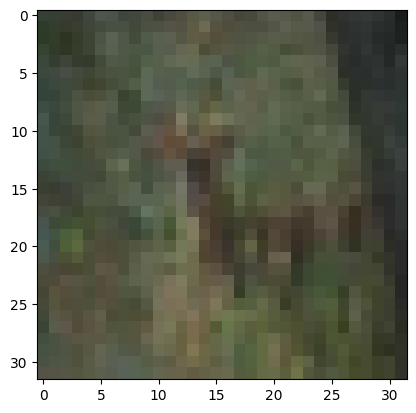

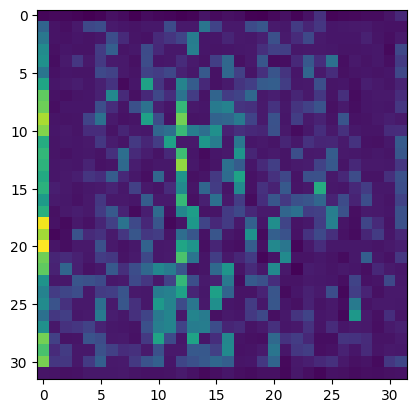

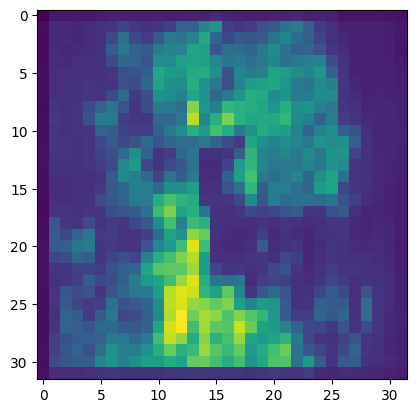

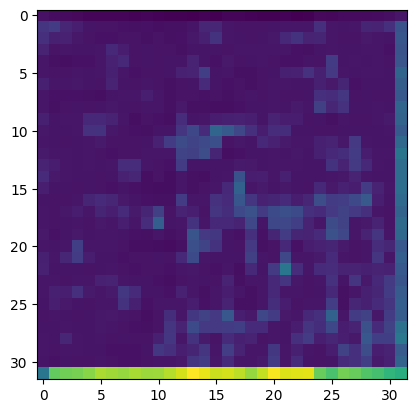

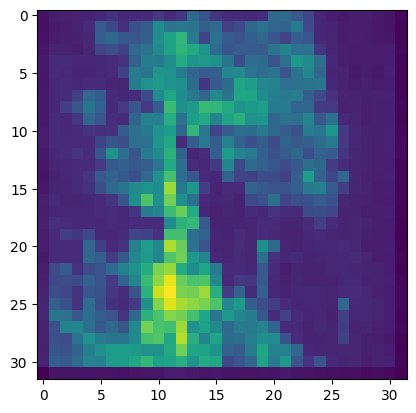

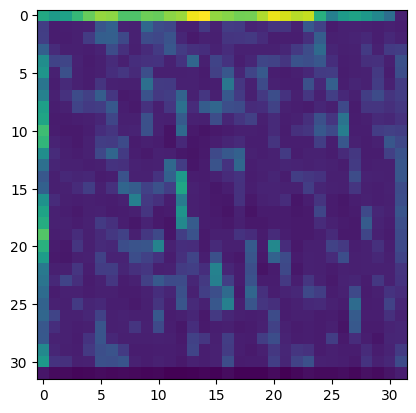

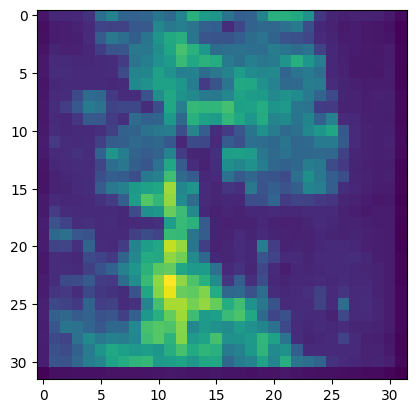

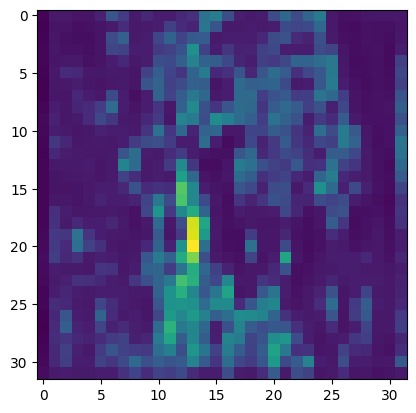

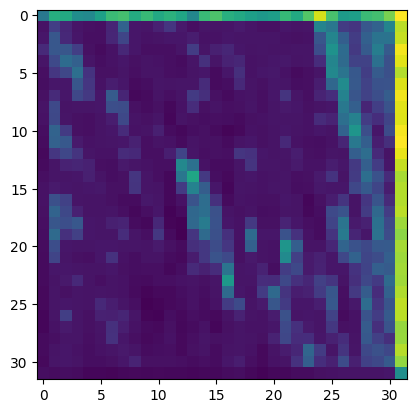

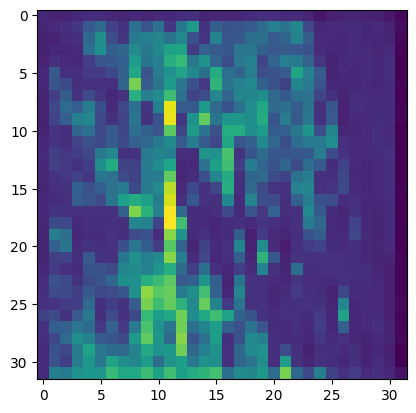

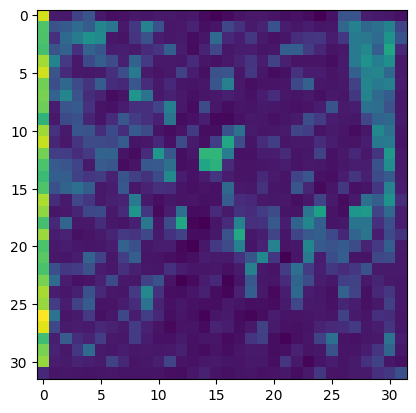

In [84]:
from torch import randint

x = cifar10.data[10]
print(x.shape)
x = ToTensor()(x)
print(x.shape)


# Test the CNNBlock
test = CNNBlock(3, 10, kernel_size=3, stride=1, padding=1)

y = test(x.unsqueeze(0)).squeeze(0)

print(y.shape)

# plot both the images side by sideusing matplotlib
import matplotlib.pyplot as plt

#plt.subplot(1, 11, 1)
plt.imshow(x.permute(1, 2, 0).detach().numpy())
plt.show()
for i in range(10):
    #plt.subplot(1, 11, i+2)
    plt.imshow(y[i].detach().numpy())
    plt.show()




In [87]:
    

resblock = ResidualBlock(64)

4